<a href="https://colab.research.google.com/github/kenichinakanishi/human_protein_classification/blob/master/fastai2_xresnet50v2_prog_resize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Run Once

In [ ]:
!pip install git+https://github.com/Kaggle/kaggle-api.git --upgrade
import os
credentials = {"username":"kenichinakanishi","key":"06fe24c1248715eb6a018cce96aadaff"}
os.environ['KAGGLE_USERNAME']=credentials["username"]
os.environ['KAGGLE_KEY']=credentials["key"]
!kaggle competitions download -c jovian-pytorch-z2g
!unzip jovian-pytorch-z2g.zip

Streaming output truncated to the last 5000 lines.
  inflating: Human protein atlas/train/3069.png  
  inflating: Human protein atlas/train/30690.png  
  inflating: Human protein atlas/train/30691.png  
  inflating: Human protein atlas/train/30692.png  
  inflating: Human protein atlas/train/30693.png  
  inflating: Human protein atlas/train/30694.png  
  inflating: Human protein atlas/train/30696.png  
  inflating: Human protein atlas/train/30697.png  
  inflating: Human protein atlas/train/30698.png  
  inflating: Human protein atlas/train/30699.png  
  inflating: Human protein atlas/train/307.png  
  inflating: Human protein atlas/train/3070.png  
  inflating: Human protein atlas/train/30700.png  
  inflating: Human protein atlas/train/30701.png  
  inflating: Human protein atlas/train/30702.png  
  inflating: Human protein atlas/train/30704.png  
  inflating: Human protein atlas/train/30706.png  
  inflating: Human protein atlas/train/30707.png  
  inflating: Human protein atlas/tr

In [ ]:
!pip install fastai2 -q

     |████████████████████████████████| 194kB 2.8MB/s 


In [ ]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 2.4MB/s 


# What is fast.ai and why use it?

[fast.ai](https://www.fast.ai/) is essentially a high-level wrapper for PyTorch, simplifying training fast and accurate neural nets using modern best practices. 

Developed by [Jeremy Howard, Rachel Thomas and Sylvain Gugger](https://www.fast.ai/about/), fastai is based on active research into deep learning best practices - meaning a lot of useful tools are built in to the library. 

fast.ai has a lot of extremely useful tutorials available on their website at [fast.ai/](https://www.fast.ai/).

In this notebook, we will leverage a number of these advanced functionalities:
- Learning rate finder
- Easy transfer learning
- [Weight decay](https://forums.fast.ai/t/new-adamw-optimizer-now-available/8518/3)
- Optimized [one cycle policy](https://docs.fast.ai/callbacks.one_cycle.html)
 - In phase 1, the learning rates goes from lr_max/div_factor to lr_max linearly while the momentum goes from moms[0] to moms[1] linearly. 
 - In phase 2, the learning rates follows a cosine annealing from lr_max to 0, as the momentum goes from moms[1] to moms[0] with the same annealing.
- Multilabel Stratification 
  - Thanks to [here](https://www.kaggle.com/ronaldokun/multilabel-stratification)
- [Modern pretrained CNN architectures](https://github.com/rwightman/gen-efficientnet-pytorch)
- [Transfer learning](https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb) to these CNN architectures


# Notes from Leslie N. Smith

https://arxiv.org/pdf/1506.01186.pdf

Good summary available [here](https://sgugger.github.io/the-1cycle-policy.html).

* Do a cycle with two steps of equal lengths, one going from a lower learning rate to a higher one than go back to the minimum. 
  * The maximum should be the value picked with the Learning Rate Finder, and the lower one can be ten times lower. 
  * Then, the length of this cycle should be slightly less than the total number of epochs, and, in the last part of training, we should allow the learning rate to decrease more than the minimum, by several orders of magnitude.
---
*   To accompany the movement toward larger learning rates, Leslie found in his experiments that decreasing the momentum led to better results. 
  * Empirically, this is not as important but is implemented in the fit_one_cycle function
---
*   Regarding weight decay, Leslie's advice is to run the learning rate finder for a few values of weight decay.
  *   Pick the largest one that will still let us train at a high maximum learning rate. 
---
*   Batch size should be set to the highest possible value to fit in the available memory.
---
* Other hyper-parameters we may have (dropout for instance) can be tuned the same way as weight decay, or just by trying on a cycle and see the results they give.




# Data

In [ ]:
DATA_DIR = '/content/Human protein atlas'

TRAIN_DIR = DATA_DIR + '/train'                           # Contains training images
TEST_DIR = DATA_DIR + '/test'                             # Contains test images

TRAIN_CSV = DATA_DIR + '/train.csv'                       # Contains real labels for training images
TEST_CSV = '/content/submission.csv'   # Contains dummy labels for test image

Google colabs has some issues with the latest version of pytorch/torchvision so we will suppress warnings

In [ ]:
import warnings
warnings.filterwarnings(action='once')

# Imports and Base Code

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import pandas as pd
import numpy as np
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.vision.widgets import *
from fastai2.vision import *
from fastai2.callback.cutmix import *

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstr

In [ ]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')


def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []


In [ ]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

# Multi-Label Classification

Many classes are under-represented, compared to the majority classes 4 and 6. 
Multi-label stratification may help our model, by ensuring that each class is properly represented during the train/validation split. 

A random split may end up being unlucky. 

4    9066
6    5711
7    2629
2    2542
0    2088
3    1977
1    1752
9    1278
5    1109
8    1037
Name: Label, dtype: int64


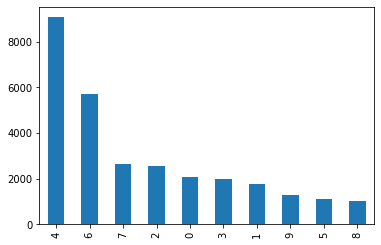

In [ ]:
df = pd.read_csv('/content/Human protein atlas/train.csv').set_index("Image")
df['Label'] = df.Label.str.split(" ") 
df = df.explode('Label') 
df.Label.value_counts().plot(kind='bar');
print(df.Label.value_counts())

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

In [ ]:
df = pd.read_csv('/content/Human protein atlas/train.csv')
onehotencoded_labels = pd.DataFrame(mlb.fit_transform(df['Label']))

In [ ]:
onehotencoded_labels.drop(0,axis=1, inplace=True)
onehotencoded_labels.columns = labels.keys()
encodedlabel_df = df.join(onehotencoded_labels)

In [ ]:
from skmultilearn.model_selection import IterativeStratification
X, y = encodedlabel_df['Image'], encodedlabel_df.iloc[0:,2:].values
k_fold = IterativeStratification(n_splits=5, order=1, random_state = 101)

splits = list(k_fold.split(X, y))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


This has split our data into 5-fold train/validation splits.
Each array has 2 dimensions, the 1st dimension are the indices of our training set ( 80% of the data ) and the second dimension are the indices of our validation set (20% of the data).

In [ ]:
print(splits[0][0].shape , splits[0][1].shape)
print(splits[1][0].shape , splits[1][1].shape)
print(splits[2][0].shape , splits[2][1].shape)
print(splits[3][0].shape , splits[3][1].shape)
print(splits[4][0].shape , splits[4][1].shape)

(15368,) (3868,)
(15401,) (3835,)
(15385,) (3851,)
(15426,) (3810,)
(15364,) (3872,)


We now set up use of the first fold.

In [ ]:
fold = 0

train_df = df.loc[splits[fold][0]]
val_df = df.loc[splits[fold][1]]
train_df['is_valid'] = False
val_df['is_valid'] = True
df = train_df.append(val_df)

# Define Transforms

In [ ]:
cell_stats = ([0.05438065, 0.05291743, 0.07920227], [0.39414383, 0.33547948, 0.38544176])

item_tfms =  [ToTensor(), 
             #Resize(128, method='squish')
             ] # These are item transforms that are applied to each image before batching

batch_tfms = [Dihedral(p=1),
             Rotate(max_deg=180, p=1),
             Zoom(max_zoom=1.05), 
             Brightness(), 
             Contrast(max_lighting=0.1),
             RandomErasing(p=0.8, sl=0.0, sh=0.3, min_aspect=0.3, max_count=5),
             IntToFloatTensor(), 
             Normalize.from_stats(*cell_stats)] # These are transforms after batching, typically prep for GPU

# Prepare Data with data_block API

We will be using the [data_block API](https://docs.fast.ai/data_block.html) to prepare our data.

- splitting data
- defining label for each image
- specify training transforms
- creating a databunch
- normalization based on entire dataset stats

Note that you should validate only on the original images. 
The augmentation is there so that it can help your model generalize better, but to evaluate your model you need actual images, not transformed ones.
The above process does this automatically, only applying the transforms to both if tfm_y is among them and if set to True.




In [ ]:
def use_partial_data(self, sample_pct:float=1.0, seed:int=None)->'ItemLists':
    "Use only a sample of the full dataset.  "
    if seed is not None: np.random.seed(seed)
    rand_idx = np.random.permutation(range_of(self))
    cut = int(sample_pct * len(self))
    return self[rand_idx[:cut]]

In [ ]:
np.random.seed(42)

get_x = lambda x: TRAIN_DIR+f'/{x[0]}.png'
get_y = lambda y: y[1].split(' ')

def stratifiedsplitter(df):                             # Define custom split based on previous stratification
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid              

blocks = (ImageBlock, MultiCategoryBlock)
                                        

In [ ]:
cell = DataBlock(blocks=blocks,                          # Define which kinds of blocks we want
                   get_x=get_x,                             # Give path to our file locations
                   splitter=stratifiedsplitter,             # Custom split defined
                   get_y=get_y,                             # Give labels
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)                            

In [ ]:
celldls = cell.dataloaders(df, bs=16)

## Sanity Check

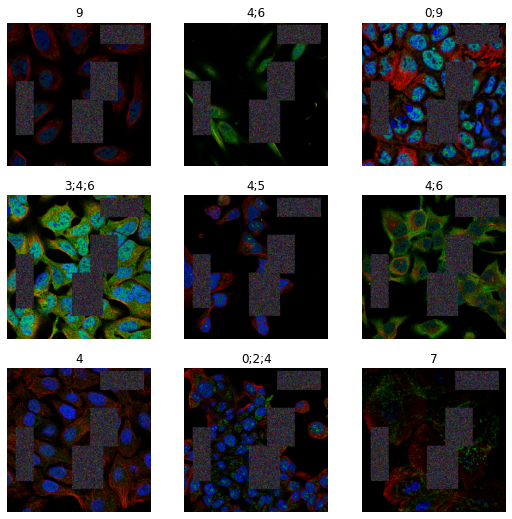

In [ ]:
celldls.train.show_batch(max_n=9)

#  Create Model


## Model Structure

# The Architecture and the new Implementations

* XResNet - Based on the [Bag of Tricks for Resnet](https://arxiv.org/abs/1812.01187) paper
* [Mish](https://arxiv.org/abs/1908.08681v1) - A new activation function that has shown fantastic results
* Ranger - A new optimizer function based on two seperate papers:
  * [On the Varience of the Adaptive Learning rate and Beyond, RAdam](https://arxiv.org/abs/1908.03265)
  * [Lookahead Optimizer: k steps forward, 1 step back](https://arxiv.org/abs/1907.08610)
* [Self-Attention](https://arxiv.org/abs/1805.08318) - Bringing in ideas from GAN's into image classification (Incorportated by Seb)
* Flatten + Anneal Scheduling - Mikhail Grankin


In [ ]:
net = xresnet50(pretrained=False, act_cls=Mish, sa=True, n_out=10)

## Create Model

In [ ]:
def F_score(output, label, threshold=0.2, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [ ]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [ ]:
f_score = partial(F_score, beta=1, threshold=0.3) # Beta = 1, as kaggle uses macro F1 Score
# Create learner

learn = Learner(celldls, 
                model=net, 
                pretrained=True,
                model_dir=DATA_DIR+'/working/',
                loss_func=BCEWithLogitsLossFlat(), 
                opt_func = ranger,
                metrics=[accuracy_multi, f_score],
                )


In [ ]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [ ]:
learn.opt_func

<function fastai2.optimizer.ranger>

In [ ]:
learn.summary()

XResNet (Input shape: ['16 x 3 x 512 x 512'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               16 x 32 x 256 x 256  864        True      
________________________________________________________________
BatchNorm2d          16 x 32 x 256 x 256  64         True      
________________________________________________________________
Mish                 16 x 32 x 256 x 256  0          False     
________________________________________________________________
Conv2d               16 x 32 x 256 x 256  9,216      True      
________________________________________________________________
BatchNorm2d          16 x 32 x 256 x 256  64         True      
________________________________________________________________
Mish                 16 x 32 x 256 x 256  0          False     
________________________________________________________________
Conv2d               16 x 64 x 256 x 256  18,432     True      
____________________________________________________

# Train Network

In [ ]:
# don't forget to remove the old file
try:
  if learn.csv_logger.path.exists(): os.remove(learn.csv_logger.path)
except:
  pass

## Transfer Learning - 512x512px

In [ ]:
learn.unfreeze()
total_params = sum(p.numel() for p in learn.model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in learn.model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

23,613,291 total parameters.
23,613,291 training parameters.


/usr/local/lib/python3.6/dist-packages/fastai2/layers.py:621: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  x = ctx.saved_variables[0]


SuggestedLRs(lr_min=0.001096478197723627, lr_steep=0.0012022644514217973)

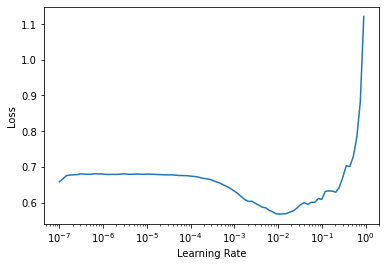

In [ ]:
learn.lr_find()

Use fit-flat-cosine

In [ ]:
learn.fit_flat_cos(10, slice(1e-3), cbs = [SaveModelCallback(monitor='F_score', fname='model_first', every_epoch=True)]) 

epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.316429,0.329438,0.864685,0.361899,11:46
1,0.268229,0.262747,0.898940,0.566853,11:44
2,0.246778,0.232309,0.907653,0.593648,11:45
3,0.231529,0.241304,0.905300,0.666311,11:45
4,0.213640,0.215971,0.915227,0.679415,11:46
5,0.204912,0.204310,0.919338,0.683880,11:46
6,0.202486,0.205985,0.919390,0.639418,11:47
7,0.198348,0.201077,0.921587,0.686096,11:47
8,0.174845,0.183558,0.929266,0.728246,11:46
9,0.166428,0.173604,0.932058,0.756021,11:46


/usr/local/lib/python3.6/dist-packages/fastai2/layers.py:621: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  x = ctx.saved_variables[0]


/usr/local/lib/python3.6/dist-packages/fastai2/layers.py:621: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  x = ctx.saved_variables[0]


SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=1.9054607491852948e-06)

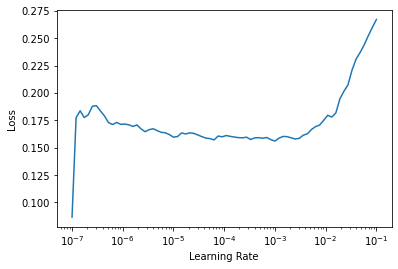

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(10, slice(5e-4), cbs = [SaveModelCallback(monitor='F_score', fname='model_second', every_epoch=True)]) 

epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.173273,0.176804,0.930610,0.731529,11:45
1,0.181084,0.177957,0.929757,0.748225,11:45
2,0.171748,0.177006,0.931153,0.745554,11:45
3,0.161865,0.173808,0.931308,0.745712,11:46
4,0.157781,0.177871,0.930300,0.745050,11:45
5,0.163586,0.175941,0.930713,0.731885,11:45
6,0.153290,0.171286,0.933170,0.753495,11:46
7,0.155813,0.176452,0.931567,0.761187,11:45
8,0.142561,0.169586,0.934282,0.759125,11:45
9,0.145929,0.168311,0.934772,0.762235,11:46


/usr/local/lib/python3.6/dist-packages/fastai2/layers.py:621: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  x = ctx.saved_variables[0]


In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(10, slice(1e-4), cbs = [SaveModelCallback(monitor='F_score', fname='model_third', every_epoch=True)]) 

epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.138376,0.173090,0.933299,0.759996,11:45
1,0.132395,0.168699,0.934462,0.768135,11:45
2,0.141892,0.170531,0.934049,0.758562,11:45
3,0.134802,0.170874,0.933868,0.760863,11:45
4,0.135951,0.169762,0.934514,0.771498,11:45
5,0.138994,0.170401,0.934514,0.766612,11:45
6,0.139425,0.168305,0.934643,0.762116,11:45
7,0.139461,0.170699,0.934514,0.765560,11:45
8,0.124577,0.168995,0.935729,0.767189,11:45
9,0.127009,0.169103,0.935600,0.766437,11:46


/usr/local/lib/python3.6/dist-packages/fastai2/layers.py:621: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  x = ctx.saved_variables[0]


In [ ]:
learn.lr_find()

In [ ]:
learn.fit_flat_cos(50, slice(1e-4), cbs = [SaveModelCallback(monitor='F_score', fname='model_fourth', every_epoch=True)]) 

epoch,train_loss,valid_loss,accuracy_multi,F_score,time
0,0.133609,0.173107,0.934617,0.764197,11:46
1,0.132103,0.172731,0.933635,0.768267,11:46
2,0.129421,0.171771,0.935134,0.769792,11:47
3,0.129432,0.173673,0.934152,0.766865,11:47
4,0.124019,0.173729,0.934617,0.765979,11:47
5,0.126272,0.172459,0.934566,0.773576,11:47
6,0.117623,0.175469,0.934643,0.767039,11:47
7,0.126352,0.172967,0.934566,0.766222,11:47
8,0.118402,0.175420,0.933661,0.777532,11:47
9,0.113505,0.176452,0.935833,0.767577,11:47


/usr/local/lib/python3.6/dist-packages/fastai2/layers.py:621: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  x = ctx.saved_variables[0]


KeyboardInterrupt: ignored

In [ ]:
learn.fit_flat_cos(50, slice(1e-4), cbs = [SaveModelCallback(monitor='F_score', fname='model_fifth', every_epoch=True)]) 

In [ ]:
help(learn.get_preds)

Help on method get_preds in module fastai2.learner:

get_preds(ds_idx=1, dl=None, with_input=False, with_decoded=False, with_loss=False, act=None, inner=False, reorder=True, save_preds=None, save_targs=None, concat_dim=0) method of fastai2.learner.Learner instance
    Get the predictions and targets on the `ds_idx`-th dbunchset or `dl`, optionally `with_input` and `with_loss`



### Plot Progress

In [ ]:
progress_log = learn.csv_logger.read_logged_file().dropna()[['train_loss','valid_loss']][2:]
progress_log.reset_index(drop=True).apply(pd.to_numeric).plot();


# Export


In [ ]:
learn.export()

# What is Test Time Augmentation?

Test time augmentation or TTA is the application of transforms to the test data before prediction. This is done five fold, then the probabilities of each class are averaged, then returned.


In [ ]:
doc(Learner.TTA)

[Internally](https://github.com/fastai/fastai/blob/master/fastai/vision/tta.py#L32), the Learner.TTA(test_data) method calls a _tta_only function, that applies image augmentation transforms. Then, a _TTA function is called which uses these defined transformations, puts the output together in a list, averages and returns the final predictions. 

The default transforms utilize the transforms that you applied to the training data, to replicate what kind of data the model is used to seeing. 
The default transforms can be seen below:

In [ ]:
augm_tfm = [o for o in learn.data.train_ds.tfms if o.tfm not in (crop_pad, flip_lr, dihedral, zoom)]

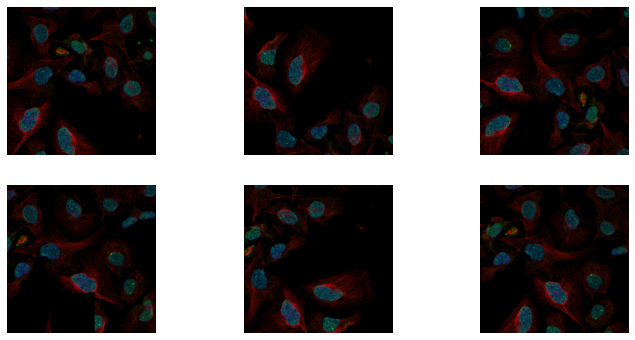

In [ ]:
row = 0 
col = 1
flip = 0
scale = 1.35 #default scale is 1.35 - probably too large, so setting to 1.0 for real TTA

d = {'row_pct':row, 'col_pct':col, 'is_random':False}
tfm = [*augm_tfm, zoom(scale=scale, **d), crop_pad(**d)]

def plots_tfms(im, rows, cols, width, height, **kwargs):
    [im.apply_tfms(tfm, **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

img = data512.valid_ds[1][0]

plots_tfms(img, 2, 3, 12, 6)

TTA prediction return probabilities, not the last activations (because they took the average of the probabilities with different data augmentation)

# Predict

Because of rare classes, macro F1 score (the metric used by Kaggle for this competition) is very sensitive to thresholds.

Hence we'd like to do a little bit of threshold manipulation to maximise the validation score we get for our trained model.


## Validation Score

Generate predictions on the validation set with using learn.get_preds (no test time augmentation).

In [ ]:
val_preds, y = learn.get_preds()

These predictions are a list of tensors, one element for each class. 
Each of these elements represent the probability (having been passed through a sigmoid function) of each class being present. 

In [ ]:
print(y[0])
print(val_preds[0])

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([8.7069e-04, 4.6553e-01, 1.1036e-03, 4.5171e-02, 6.3127e-01, 2.0751e-05,
        1.5553e-01, 2.9640e-01, 5.5863e-02, 3.5102e-03])


## Calculate Best Thresholds

## Flat Thresholds

In [ ]:
def F_score(output, label, threshold=0.2, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [ ]:
F_score(val_preds, y, threshold=0.2)

tensor(0.8776)

In [ ]:
doc(fbeta)

In [ ]:
f_scores = []
threshold_range = np.arange(0,1,0.01)
for t in threshold_range:
  f1_score = F_score(val_preds, y, threshold=t)
  f2_score = F_score(val_preds, y, threshold=t, beta=2)
  f_scores.append([t, float(f1_score), float(f2_score), float(f1_score_2)])

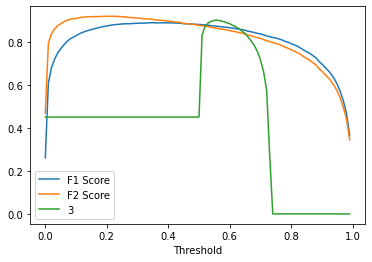

In [ ]:
f_scores = pd.DataFrame(f_scores).rename({0:'Threshold',1:'F1 Score',2:'F2 Score'},axis=1).set_index('Threshold')
f_scores.plot();

In [ ]:
#Best threshold value for this data
f_scores[f_scores['F1 Score']== f_scores['F1 Score'].max()]

,F1 Score,F2 Score,3
Threshold,,,
0.35,0.89215,0.907935,0.45179


In [ ]:
#Best threshold value for this data
f_scores[f_scores['F2 Score']== f_scores['F2 Score'].max()]

,F1 Score,F2 Score,3
Threshold,,,
0.21,0.879762,0.922322,0.45179


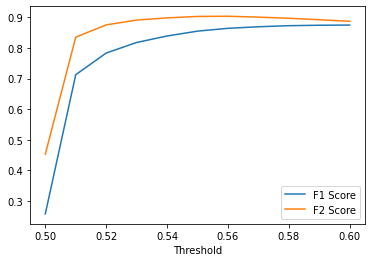

In [ ]:
f_scores.loc[0.5:0.6].plot();

In [ ]:
from scipy.optimize import minimize
f_score_complement = partial(fbeta_custom, y_pred = preds, y_true = y, beta = 2) # F2-Score
scipy.optimize.Bounds(0,1)
res = minimize(f_score_complement, 0.5,
               method='powell',
               bounds=(0,1),
               options={'xtol': 1e-8})
res.x # Optimized F2-Score threshold

print(f'The best F2-Score is {1-res.fun}, at threshold {res.x}')

The best F2-Score is 0.4615705907344818, at threshold -1.1180319340237879


/usr/local/lib/python3.6/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method powell cannot handle constraints nor bounds.
  RuntimeWarning)


In [ ]:
from scipy.optimize import minimize
f_score_complement = partial(fbeta_custom, y_pred = preds, y_true = y, beta = 1) # F1-Score
scipy.optimize.Bounds(0,1)
res = minimize(f_score_complement, 0.54,
               method='powell',
               options={'xtol': 1e-5})
res.x # Optimized F2-Score threshold

print(f'The best F1-Score is {1-res.fun}, at threshold {res.x}')

The best F1-Score is 0.480701744556427, at threshold 0.5397429190855988


## Individual thresholds

To do this, we take the default fbeta function defined in the fast.ai documentation, and alter it such that the main variable taken in is the threshold vector. 

In [ ]:
def fbeta_custom(thresh:float, y_pred:Tensor=preds, y_true:Tensor=y, beta:float=2, eps:float=1e-9, sigmoid:bool=True)->Rank0Tensor:
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>torch.tensor(thresh)).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return 1-float(res.mean())

In [ ]:
threshold_categories

[0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54]

In [ ]:
f_score_complement = partial(fbeta_custom, y_pred = preds, y_true = y)
f_score_complement(threshold_categories)

0.4560263752937317

In [ ]:
import scipy.optimize as opt
best_threshold = f_scores[f_scores['F1 Score']== f_scores['F1 Score'].max()].index[0]
threshold_categories = [best_threshold]*10



In [ ]:
# Optimize F1-Score
f_score_complement = partial(fbeta_custom, y_pred = preds, y_true = y, beta = 1) # F1-Score
res = minimize(f_score_complement, threshold_categories,
               method='powell',
               options={'xtol': 1e-8})

print(f'The best F1-Score is {1-res.fun}, at threshold {res.x}')

The best F1-Score is 0.5350877642631531, at threshold [0.534975 5.776061 0.54     5.776061 0.556772 5.776061 0.531371 5.776061 5.776061 5.776061]


In [ ]:
# Optimize F1-Score
f_score_complement = partial(fbeta_custom, y_pred = preds, y_true = y, beta = 2) # F2-Score
res = minimize(f_score_complement, threshold_categories,
               method='powell',
               options={'xtol': 1e-8})

print(f'The best F2-Score is {1-res.fun}, at threshold {res.x}')

The best F2-Score is 0.6310531497001648, at threshold [ 0.54      8.394092 -0.1682    8.394092  0.662464  8.394092  0.523932  0.505422  8.394092  8.394092]


# Generate Predictions

In [ ]:
#learn_test = load_learner(DATA_DIR, test=test, num_workers=0, bs=32) # Load model
#learn_test.load('/content/Human protein atlas/working/best'); # Load weights
learn.load('/content/Human protein atlas/working/best'); # Load best weights into our model

In [ ]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
preds_tta, _ = learn.TTA(ds_type=DatasetType.Test, scale = 1.0)

In [ ]:
preds.shape

torch.Size([19, 10])

In [ ]:
print(preds[:5])

tensor([[1.0764e-04, 7.7319e-02, 6.1337e-02, 2.9880e-02, 7.0191e-01, 1.6038e-02,
         9.7360e-01, 2.5840e-01, 6.4447e-04, 4.7207e-03],
        [2.3043e-02, 4.9420e-02, 1.4508e-04, 2.2271e-01, 3.4343e-02, 7.0364e-05,
         4.2099e-01, 4.1233e-01, 3.0625e-06, 2.2543e-02],
        [2.4453e-05, 9.0583e-03, 2.6047e-01, 1.5500e-02, 9.9936e-01, 1.4962e-06,
         1.7289e-02, 2.2027e-01, 3.5321e-08, 4.1383e-03],
        [2.4768e-03, 8.9271e-02, 1.0241e-03, 2.5458e-02, 9.7610e-01, 4.8692e-02,
         9.7845e-01, 7.7217e-06, 7.5819e-04, 1.2271e-03],
        [6.1588e-03, 4.6229e-03, 3.9094e-02, 3.2171e-01, 9.9996e-01, 7.9497e-04,
         9.7119e-02, 1.5990e-05, 3.4768e-04, 1.8800e-04]])


Look at proportion of label predictions

In [ ]:
labels = labelled_preds
label_count = np.zeros(10)
for label in labels['Label']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(10)[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

NameError: ignored

# Generate CSV

In [ ]:
thresh = 0.35
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
fnames = [f.name[:-4] for f in learn.data.test_ds.x.items]
df = pd.DataFrame({'Image':fnames, 'Label':labelled_preds}, columns=['Image', 'Label'])
df.to_csv('fastai_efficientnet_035.csv', index=False)


In [ ]:
thresh = 0.35
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds_tta]
fnames = [f.name[:-4] for f in learn.data.test_ds.x.items]
df = pd.DataFrame({'Image':fnames, 'Label':labelled_preds}, columns=['Image', 'Label'])
df.to_csv('fastai_efficientnet_TTA_035.csv', index=False)


In [ ]:
thresh = 0.21
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
fnames = [f.name[:-4] for f in learn.data.test_ds.x.items]
df = pd.DataFrame({'Image':fnames, 'Label':labelled_preds}, columns=['Image', 'Label'])
df.to_csv('fastai_efficientnet_021.csv', index=False)


In [ ]:
thresh = 0.21
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds_tta]
fnames = [f.name[:-4] for f in learn.data.test_ds.x.items]
df = pd.DataFrame({'Image':fnames, 'Label':labelled_preds}, columns=['Image', 'Label'])
df.to_csv('fastai_efficientnet_TTA_021.csv', index=False)


# Notes

 Densenet 121 - 5% data - 0.7124130725860596 F2 Score - 

# Considerations

[Whale Classification](https://medium.com/@ducha.aiki/thanks-radek-7th-place-solution-to-hwi-2019-competition-738624e4c885)


* [Center Loss](https://ydwen.github.io/papers/WenECCV16.pdf)

A new supervision signal, called center loss, for face recognition
task. Specifically, the center loss simultaneously learns a center for deep
features of each class and penalizes the distances between the deep features and their corresponding class centers

*Our data does not have any central feature. I don't feel that this would be appropriate given the cell proteins can be distributed randomly across the image*